# Robust Data-Driven Portfolio Diversification
### Francisco A. Ibanez

1. RPCA on the sample
2. Singular Value Hard Thresholding (SVHT)
3. Truncated SVD
4. Maximize portfolio effective bets - regualization, s.t.: 
    - Positivity constraint
    - Leverage 1x

The combination of (1), (2), and (3) should limit the possible permutations of the J vector when doing the spectral risk parity.

## Methodology
The goal of the overall methodology is to arrive to a portfolio weights vector which provides a well-balanced portfolio exposure to each one of the spectral risk factors present in an given investable universe.

We start with the data set $X_{T \times N}$ which containst the historical excess returns for each one of the assets that span the investable universe of the portfolio. Before performing the eigendecomposition on $X$, we need to clean the set from noisy trading observations and outliers. We apply Robust Principal Components (RPCA) on $X$ to achieve this, which seeks to decompose $X$ into a structured low-rank matrix $R$ and a sparse matrix $C$ containing outliers and corrupt data:

\begin{aligned}
X=R_0+C_0
\end{aligned}

The principal components of $R$ are robust to outliers and corrupt data in $C$. Mathematically, the goal is to find $R$ and $C$ that satisfy the following:

\begin{aligned}
\min_{R,C} ||R||_{*} + \lambda ||C||_{1} \\
\text{subject to} \\ R + C = X
\end{aligned} 

In [20]:
import pandas as pd
import numpy as np
from rpca import RobustPCA
import matplotlib.pyplot as plt
from scipy.linalg import svd
from optht import optht

raw = pd.read_pickle('etf_er.pkl')
sample = raw.dropna() # Working with even panel for now

# Outlier detection & cleaning
X = (sample - sample.mean()).div(sample.std()).values  # Normalization
t, n = X.shape
lmb = 4 / np.sqrt(max(t, n))  # Hyper-parameter
rob = RobustPCA(lmb=lmb, max_iter=int(1E6))
R, C = rob.fit(X)  # Robust, Corrupted

# Low-rank representation (compression) through hard thresholding Truncated-SVD
U, S, Vh = svd(R, full_matrices=False, compute_uv=True, lapack_driver='gesdd')
S = np.diag(S)
k = optht(X, sv=np.diag(S), sigma=None)

V = Vh.T
Vhat = V.copy()
Vhat[:, k:] = 0
Shat = S.copy()
Shat[k:, k:] = 0

cum_energy = np.cumsum(np.diag(S)) / np.sum(np.diag(S))
print(f'SVHT: {k}, {round(cum_energy[k] * 100, 2)}% of energy explained')

SVHT: 8, 58.43% of energy explained


In [26]:
D = np.diag(sample.std().values)
t, n = X.shape
w = np.array([1 / n] * n).reshape(-1, 1)
eigen_wts = V.T @ D @ w
p = np.divide(np.diag(eigen_wts.flatten()) @ S.T @ S @ eigen_wts, w.T @ D @ R.T @ R @ D @ w)
p = p.flatten()
eta_p = np.exp(-np.sum(np.multiply(p, np.log(p))))
eta_p

1.4535327279694732

In [65]:
def effective_bets(weights, singular_values_matrix, eigen_vector_matrix, volatilities, k=None):
    w = weights.reshape(-1, 1)
    eigen_wts = eigen_vector_matrix.T @ np.diag(volatilities) @ w
    p = (np.diag(eigen_wts.flatten()) @ singular_values_matrix.T @ singular_values_matrix @ eigen_wts).flatten()
    if k != None:
        p = p[:k]
    p_norm = np.divide(p, p.sum())
    eta = np.exp(-np.sum(np.multiply(p_norm, np.log(p_norm))))
    return eta

effective_bets(np.array([1 / n] * n), S, V, sample.std().values)


1.4535327279694745

In [85]:
def objfunc(weights, singular_values_matrix, eigen_vector_matrix, volatilities, k=None):
    return -effective_bets(weights, singular_values_matrix, eigen_vector_matrix, volatilities, k)

# Testing if minimizing p.T @ p yields the same results as maximizing the effective numbers of bets 
def objfunc2(weights, singular_values_matrix, eigen_vector_matrix, volatilities, k=None):
    w = weights.reshape(-1, 1)
    eigen_wts = eigen_vector_matrix.T @ np.diag(volatilities) @ w
    p = np.diag(eigen_wts.flatten()) @ singular_values_matrix.T @ singular_values_matrix @ eigen_wts
    if k != None:
        p = p[:k]
    n = p.shape[0]
    p_norm = np.divide(p, p.sum())
    c = np.divide(np.ones((n, 1)), n)
    return ((p_norm - c).T @ (p_norm - c)).item()

8.196506038023736


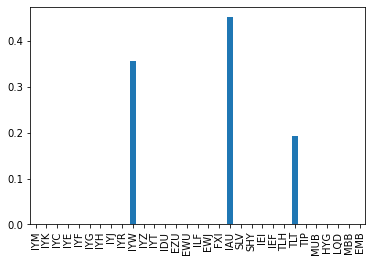

In [102]:
# POSITIVE ONLY
from scipy.optimize import minimize

cons = (
    {'type': 'ineq', 'fun': lambda x: x},
    {'type': 'ineq', 'fun': lambda x: np.sum(x) - 1}
)

opti = minimize(
    fun=objfunc,
    x0=np.array([1 / n] * n),
    args=(S, V, sample.std().values),
    constraints=cons,
    method='SLSQP',
    tol=1E-12,
    options={'maxiter': 1E9}
)

w_star = opti.x
w_star /= w_star.sum() 
pd.Series(w_star, index=sample.columns).plot.bar()
print(-opti.fun)

30.999999993097827


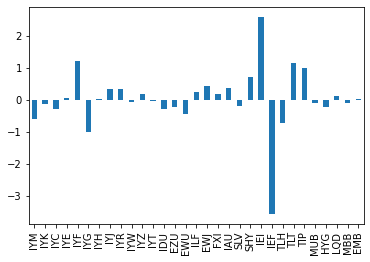

In [105]:
# UNCONSTRAINED
from scipy.optimize import minimize

cons = (
    {'type': 'ineq', 'fun': lambda x: x},
    {'type': 'ineq', 'fun': lambda x: np.sum(x) - 1}
)

opti = minimize(
    fun=objfunc,
    x0=np.array([1 / n] * n),
    args=(S, V, sample.std().values),
#    constraints=cons,
    method='SLSQP',
    tol=1E-12,
    options={'maxiter': 1E9}
)

w_star = opti.x
w_star /= w_star.sum() 
pd.Series(w_star, index=sample.columns).plot.bar()
print(-opti.fun)

<AxesSubplot:>

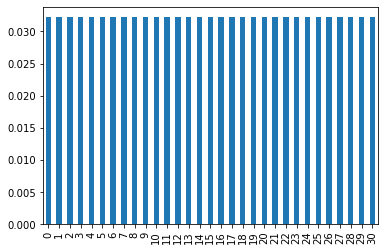

In [106]:
eigen_wts = V.T @ np.diag(sample.std().values) @ w_star.reshape(-1, 1)
p = (np.diag(eigen_wts.flatten()) @ S.T @ S @ eigen_wts).flatten()
p = np.divide(p, p.sum())
pd.Series(p).plot.bar()

5.142484857977732


<AxesSubplot:>

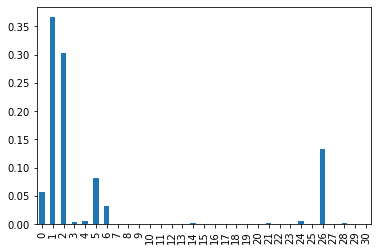

In [107]:
# RC.T @ RC... different?
cons = (
    {'type': 'ineq', 'fun': lambda x: x},
    {'type': 'ineq', 'fun': lambda x: np.sum(x) - 1}
)

opti = minimize(
    fun=objfunc2,
    x0=np.array([1 / n] * n),
    args=(S, V, sample.std().values),
    constraints=cons,
    method='SLSQP',
    tol=1E-12,
    options={'maxiter': 1E9}
)

w_star = opti.x
w_star /= w_star.sum()
#pd.Series(w_star, index=sample.columns).plot.bar()
print(effective_bets(w_star, S, V, sample.std().values))
S, V, sample.std().values

eigen_wts = V.T @ np.diag(sample.std().values) @ w_star.reshape(-1, 1)
p = (np.diag(eigen_wts.flatten()) @ S.T @ S @ eigen_wts).flatten()
p = np.divide(p, p.sum())
pd.Series(p).plot.bar()

In [72]:
np.array([1, 2, 3]).shape

(3,)

In [ ]:
D = np.diag(sample.std().values)
n = sample.shape[0]
Sigma = 1 / (n - 1) * D @ X.T @ X @ D
Sigma_b = 1 / (n - 1) * D @ (R + C).T @ (R + C) @ D

pd.DataFrame(R.T @ C)
pd.DataFrame(R.T @ C) + pd.DataFrame(C.T @ R)
pd.DataFrame(R.T @ R) + pd.DataFrame(C.T @ C)

\begin{aligned}
X &= R + C \\
R &= USV^{T}
\end{aligned}

using the Singular Value Hard Thresholding (SVHT) obtained above we can approximate $R$:
\begin{aligned}
R &\approx \tilde{U}\tilde{S}\tilde{V}^{T}
\end{aligned}

Check the algebra so everything add up and the first matrix $X$ can be recovered from this point.

\begin{aligned}
\Sigma &= \frac{1}{(n - 1)}DX^{T}XD \\
\Sigma &= \frac{1}{(n - 1)}D(R + C)^{T}(R + C))D
\end{aligned}

then, portfolio risk will be given by:
\begin{aligned}
w^{T}\Sigma w &= \frac{1}{(n - 1)}w^{T}D(R + C)^{T}(R + C))D w \\
w^{T}\Sigma w &= \frac{1}{(n - 1)}w^{T}D(R^{T}R + R^{T}C + C^{T}R + C^{T}C ) D w \\
\end{aligned}



\begin{aligned}
w^{T}\Sigma w &= \frac{1}{(n - 1)} \lbrack w^{T}D(R^{T}R)Dw + w^{T} D(R^{T}C + C^{T}R + C^{T}C ) D w \rbrack
\end{aligned}


Taking the Singular Value Decomposition of R

\begin{aligned}
R &= USV^{T} \\
\end{aligned}

we can express R in terms of its singular values and eigenvectors:

\begin{aligned}
w^{T}\Sigma w &= (n - 1)^{-1} \lbrack w^{T}D(VSU^{T}USV^{T})Dw + w^{T} D(R^{T}C + C^{T}R + C^{T}C) D w \rbrack \\
w^{T}\Sigma w &= (n - 1)^{-1} \lbrack w^{T}D(V S^{2} V^{T})Dw + w^{T} D(R^{T}C + C^{T}R + C^{T}C) D w \rbrack
\end{aligned}

where $S^{2}$ contains the eigenvalues of $R$ in its diagonal entries

\begin{aligned}
w^{T}\Sigma w &= (n - 1)^{-1} \lbrack \underbrace{w^{T}DV S^{2} V^{T}Dw}_\text{Robust Component} 
+ \underbrace{w^{T} D(R^{T}C + C^{T}R + C^{T}C) D w}_\text{Noisy Component} \rbrack
\end{aligned}

TO DO: There has to be a way of reducing the noisy component, or at least interpret/explain it.

The portfolio risk contribution is then given by 

\begin{aligned}
diag(w)\Sigma w &= (n - 1)^{-1} \lbrack \underbrace{\theta}_\text{Robust Component} 
+ \underbrace{\gamma}_\text{Noisy Component} \rbrack \\

\theta &= diag(V^{T}Dw)S^{2} V^{T}Dw

\end{aligned}

\begin{align}
\eta (w) & \equiv \exp \left( -\sum^{N}_{n=1} p_{n} \ln{(p_{n})} \right)
\end{align}

Now we look for:
\begin{align}
\arg \max_{w} \eta(w)
\end{align}
